# Assignment 2: Feature Matching, Image Stitching

ECSE 415 Introduction to Computer Vision

Instructor: James Clark

Ann Trinh 260985522

In [189]:
path = '/content/drive/My Drive/McGill Jazz/Courses/ECSE 415/A2/images/'

In [190]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
# importing libraries used throughout the assignment
import matplotlib.pyplot as plt
import cv2
import numpy as np

## 1 Harris Corner Detection

In [192]:
# load and convert image to grayscale
img = cv2.imread(path + "mcgill_arts_building.jpg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [193]:
# compute image derivatives
I_x = cv2.Sobel(img_gray, cv2.CV_32F, 1, 0, ksize=5)
I_y = cv2.Sobel(img_gray, cv2.CV_32F, 0, 1, ksize=5)

I_xx = I_x * I_x
I_yy = I_y * I_y
I_xy = I_x * I_y

In [194]:
# apply gaussian filtering
I_xx_smooth = cv2.GaussianBlur(I_xx, (5, 5), 1)
I_yy_smooth = cv2.GaussianBlur(I_yy, (5, 5), 1)
I_xy_smooth = cv2.GaussianBlur(I_xy, (5, 5), 1)

In [195]:
# compute the corner response
# R = det(H) - alpha * (trace(H))**2
# R = (I_xx * I_yy - I_xy**2) - alpha * (I_xx + I_yy)**2
alpha = 0.05
R = ((I_xx_smooth * I_yy_smooth) - (I_xy_smooth**2)) - (alpha * ((I_xx_smooth + I_yy_smooth)**2))

In [196]:
# function for non-maximum suppression
def non_max_suppression(img):

    M, N = img.shape
    Z = np.zeros_like(img)

    for i in range(1, M-1):
      for j in range(1, N-1):
        # get the neighbouring pixels
        region = img[i-1 : i+1+1, j-1 :j+1+1]
        if img[i, j] >= np.max(region):
          Z[i, j] = img[i, j]
        else:
          Z[i, j] = 0

    return Z

In [197]:
# perform non-maximum suppression to corner response map
Z = non_max_suppression(R)

### Experiment with Thresholds

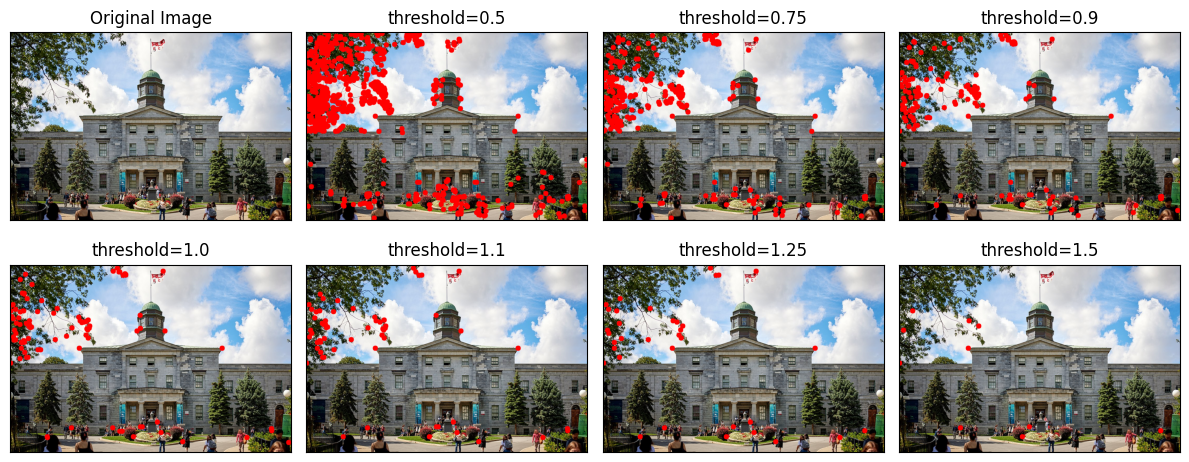

In [198]:
# detecting and marking corners + experiment with thresholds

# normalize corner response (after non max suppression) to [0, 2]
cv2.normalize(Z, Z, 0, 2, cv2.NORM_MINMAX)

# threshold list
thres_list = [0.5, 0.75, 0.9, 1.0, 1.1, 1.25, 1.5]
# starting point for subplots
subplot = 242

plt.figure(figsize=(12, 5))
plt.subplot(241), plt.imshow(img_RGB)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

for thres in thres_list:
  # copy original image
  img_disp = img_RGB.copy()

  # list all points higher than threshold
  loc = np.where(Z >= thres)

  # loop though points
  for pt in zip(*loc[::-1]):
      # draw filled circle on each point
      cv2.circle(img_disp, pt, 10, (255,0,0), -1)

  plt.subplot(subplot), plt.imshow(img_disp)
  plt.title(f"threshold={thres}"), plt.xticks([]), plt.yticks([])

  subplot += 1

# display images
plt.tight_layout()
plt.show()

Above are 6 plots. The top leftmost plot is the orginal image and the other 5 are of the original image with marked corners using varying thresholds.

The corners of the Arts Building most captured in the given images are the outer convexed ones and parts of the jutting tower. This makes sense as concave corners would not be detected using this method. People are also being detected in the images, this could happen if the clothes of the person have a high contrast with the background.

Notice also, that while lower thresholds give more corners of the building they also detect the corners of the people and the tree in the top left corner of the image. This could pose a problem as the tree and or the people may not be the target object. However, as we increase the threshold, less corners of the bulding are detected.

## 2 SIFT Features

### 2.1 SIFT Keypoint Matching Between Two Images

In [199]:
def sift_keypoint_matching(img_a, img_b):
  # compute SIFT keypoints and descriptors
  # copy images
  img_a_disp = img_a.copy()
  img_b_disp = img_b.copy()

  # create a SIFT detector
  sift = cv2.SIFT_create()

  # detect keypoints
  keypoints_a = sift.detect(img_a, None)
  keypoints_b = sift.detect(img_b, None)

  # compute SIFT descriptors
  keypoints_a, descriptors_a = sift.compute(img_a, keypoints_a)
  keypoints_b, descriptors_b = sift.compute(img_b, keypoints_b)

  # match keypoints
  # create BFMatcher
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

  # match descriptors
  matches = bf.match(descriptors_a, descriptors_b)

  # sort matches by distance
  matches = sorted(matches, key = lambda x:x.distance)

  # draw first 10 matches
  img_matches = cv2.drawMatches(img_a, keypoints_a, img_b, keypoints_b, matches[:10], None, flags=2)

  return matches, img_matches

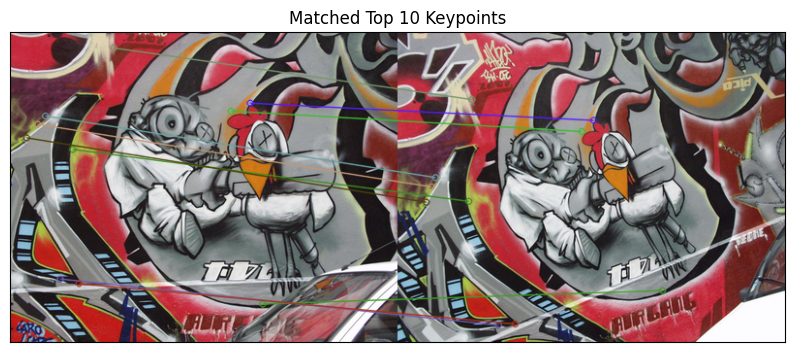

In [200]:
# load images
img_a = cv2.cvtColor(cv2.imread(path + "graf1.png"), cv2.COLOR_BGR2RGB)
img_b = cv2.cvtColor(cv2.imread(path + "graf2.png"), cv2.COLOR_BGR2RGB)

# get keypoints, descriptors, and matches
matches, img_matches = sift_keypoint_matching(img_a, img_b)

# display top 10 matches on images
plt.figure(figsize=(10, 10))
plt.imshow(img_matches)
plt.title("Matched Top 10 Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

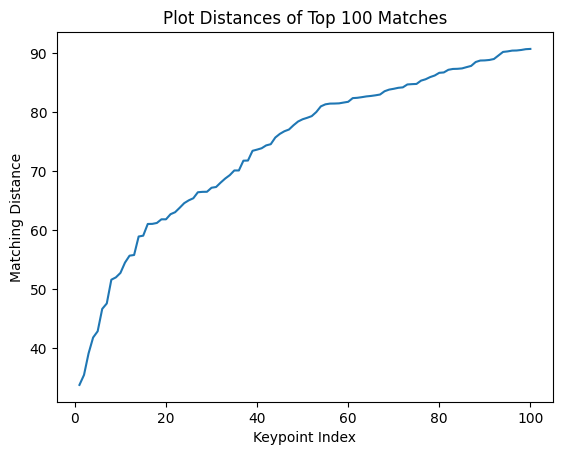

In [201]:
# plot the matching distances for the top 100 matches
x_values = range(1, 101)
y_values = [m.distance for m in matches[:100]]

plt.plot(x_values, y_values)
plt.title("Plot Distances of Top 100 Matches")
plt.xlabel("Keypoint Index")
plt.ylabel("Matching Distance")
plt.show()

### 2.2 Scale Invariance


In [202]:
# scale the original image
def scale_images(img, scale_factors):
  img_noscale = img.copy()
  scaled_images = []

  for sf in scale_factors:
  # scale original to 4 different images
    img_scaled = cv2.resize(img_noscale, (0,0), fx=sf, fy=sf)
    scaled_images.append(img_scaled)

  return scaled_images

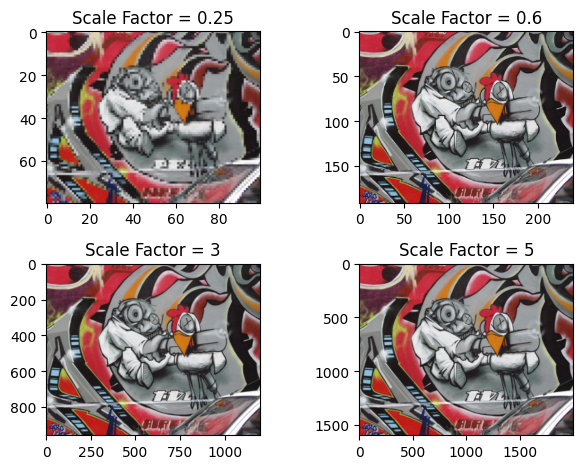

In [203]:
def display_scaled_images(scale_factors, scaled_images):
  # display scaled images
  subplot = 221
  for i in range(4):
    plt.subplot(subplot), plt.imshow(scaled_images[i])
    plt.title(f"Scale Factor = {scale_factors[i]}")
    subplot += 1

  plt.tight_layout()
  plt.show()

scale_factors = [0.25, 0.6, 3, 5]
scaled_images = scale_images(img_a, scale_factors)
display_scaled_images(scale_factors, scaled_images)

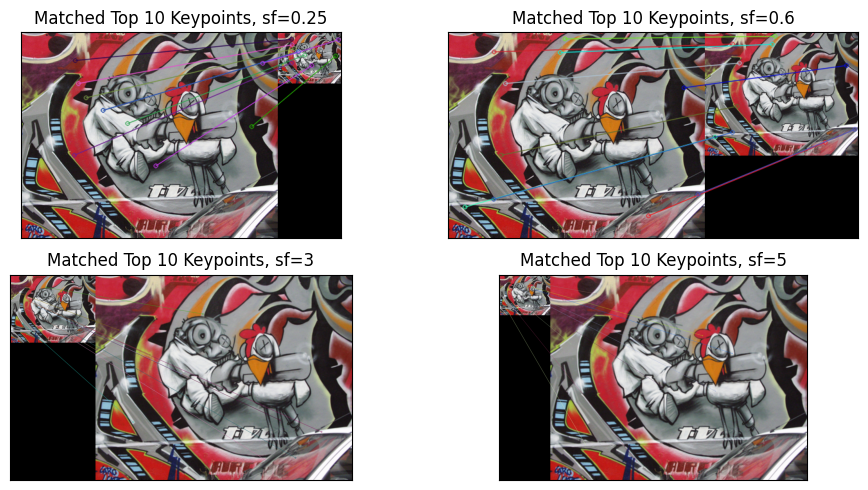

In [204]:
def display_scaled_matchings(img, scaled_images, scale_factors):
  img_disp = img.copy()
  matches_list = []

  subplot = 221
  plt.figure(figsize=(10, 5))
  for i in range(4):
    # use the function defined above to get the sift matchings
    matches, img_matches = sift_keypoint_matching(img_disp, scaled_images[i])
    # add image to be displayed
    plt.subplot(subplot), plt.imshow(img_matches)
    plt.title(f"Matched Top 10 Keypoints, sf={scale_factors[i]}"), plt.xticks([]), plt.yticks([])
    subplot += 1
    matches_list.append(matches)

  plt.tight_layout()
  plt.show()

  return matches_list

matches_list = display_scaled_matchings(img_a, scaled_images, scale_factors)

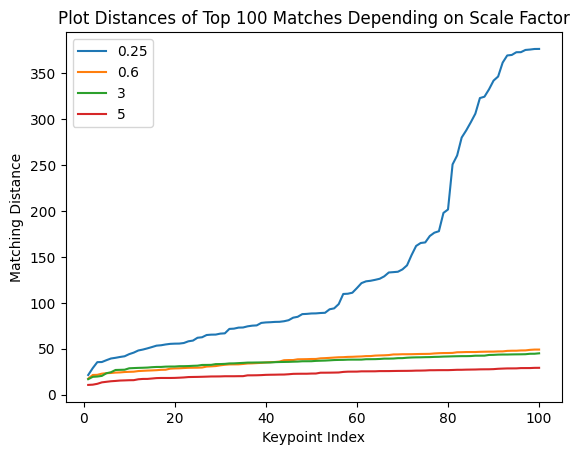

In [205]:
for i in range(4):
  # plot the matching distances for the top 100 matches
  x_values = range(1, 101)
  y_values = [m.distance for m in matches_list[i][:100]]

  plt.plot(x_values, y_values)

plt.legend(scale_factors)
plt.title("Plot Distances of Top 100 Matches Depending on Scale Factor")
plt.xlabel("Keypoint Index")
plt.ylabel("Matching Distance")
plt.show()

### Discuss Trends
As we increased the scaling factor the matching distances were smaller. Most notably if we compared the plot for 0.25 and 5, the distances for a scaling factor of 0.25 were much larger than those for a scaling factor of 5. It is also interesting that for scaling factors of 0.6, 3, and 5 produce very similar shapes.

### 2.3 Rotation Invariance

In [206]:
def rotate_images(img, rotation_degree_list):
  height, width = img.shape[0:2]
  rotated_images = []

  # create a rotated image
  for rd in rotation_degree_list:
    M = cv2.getRotationMatrix2D((width/2, height/2), rd, 1.0)
    img_rotated = cv2.warpAffine(img, M, (width, height))
    rotated_images.append(img_rotated)

  return rotated_images

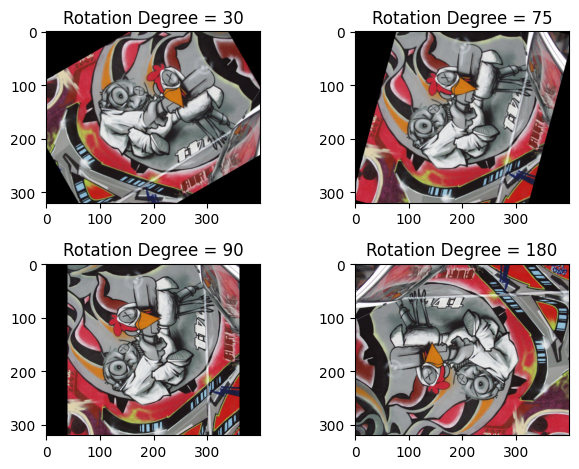

In [207]:
def display_rotated_images(rotation_degrees, rotated_images):
  # display images
  subplot = 221
  for i in range(4):
    plt.subplot(subplot), plt.imshow(rotated_images[i])
    plt.title(f"Rotation Degree = {rotation_degrees[i]}")
    subplot += 1

  plt.tight_layout()
  plt.show()

rotation_degrees = [30, 75, 90, 180]
rotated_images = rotate_images(img_a, rotation_degrees)
display_rotated_images(rotation_degrees, rotated_images)

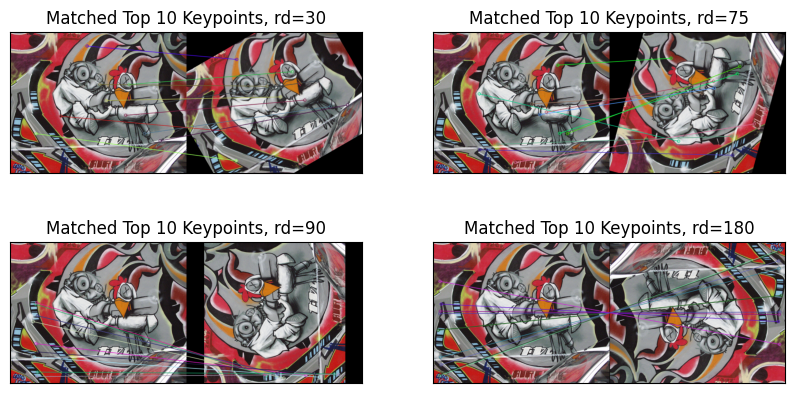

In [208]:
def display_rotated_matchings(img, rotated_images, rotation_degrees):
  img_disp = img.copy()
  matches_list = []

  subplot = 221
  plt.figure(figsize=(10, 5))
  for i in range(4):
    # use the function defined above to get the sift matchings
    matches, img_matches = sift_keypoint_matching(img_disp, rotated_images[i])
    # add image to be displayed
    plt.subplot(subplot), plt.imshow(img_matches)
    plt.title(f"Matched Top 10 Keypoints, rd={rotation_degrees[i]}"), plt.xticks([]), plt.yticks([])
    subplot += 1
    matches_list.append(matches)

  return matches_list

  plt.tight_layout()
  plt.show()

matches_list = display_rotated_matchings(img_a, rotated_images, rotation_degrees)

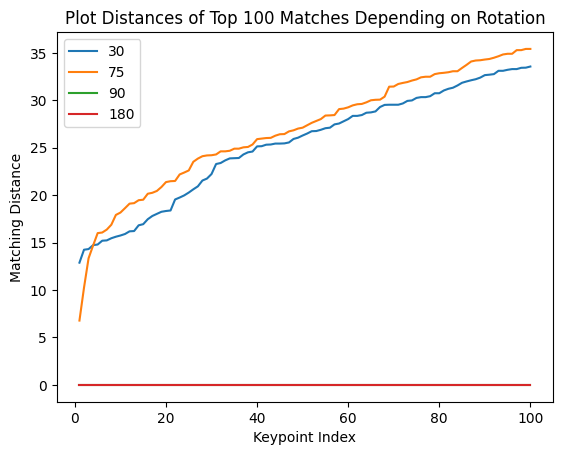

In [209]:
for i in range(4):
  # plot the matching distances for the top 100 matches
  x_values = range(1, 101)
  y_values = [m.distance for m in matches_list[i][:100]]

  plt.plot(x_values, y_values)

plt.legend(rotation_degrees)
plt.title("Plot Distances of Top 100 Matches Depending on Rotation")
plt.xlabel("Keypoint Index")
plt.ylabel("Matching Distance")
plt.show()

### Discuss Trends
We see that for rotation degrees 30 and 75 the top 100 matched distances following a similar trajectory. Interestingly, for 90 and 180, the matching distances are 0 (or close to) which could be the result of a computation mistake but could also have to do with the fact that these angles are multiples of 90.

### 2.4 Using my own Image Pair

In [210]:
from skimage.transform import resize

# function developed in assignment 1
def resize_img(img):
  scale_factor = 0

  # identifying the largest dimension and getting the scale factor
  if img.shape[0] > img.shape[1]:
    scale_factor = 400.0 / img.shape[0]
  else:
    scale_factor = 400.0 / img.shape[1]

  # resize using the calculated scale factor
  resized = resize(
    img, (int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), anti_aliasing=True
  )

  resized = (resized * 255).astype(np.uint8)

  return resized

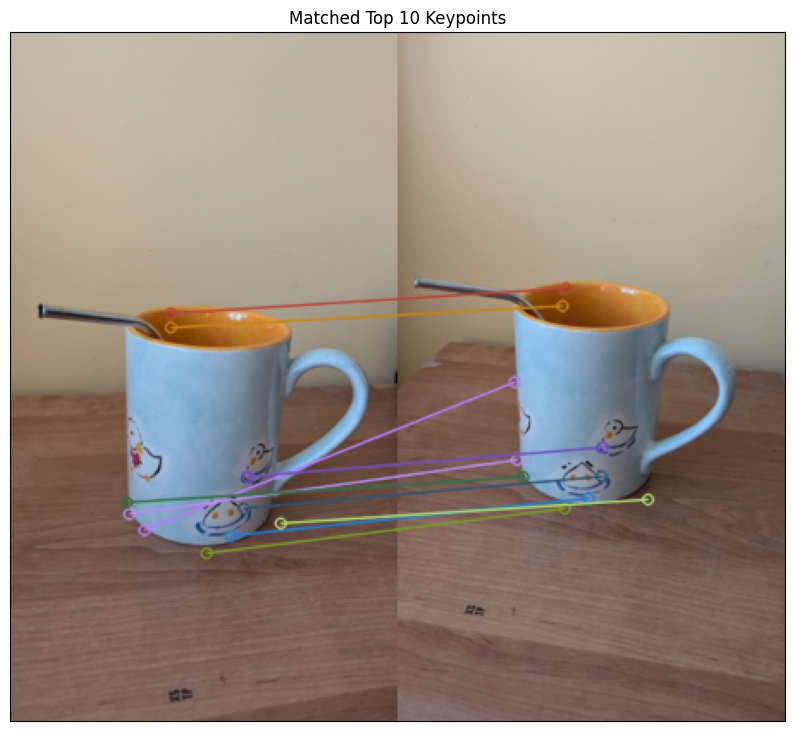

In [211]:
# SIFT Keypoint Matching Between Two Images

# load images
img_a = cv2.cvtColor(cv2.imread(path + "cup1.jpg"), cv2.COLOR_BGR2RGB)
img_b = cv2.cvtColor(cv2.imread(path + "cup2.jpg"), cv2.COLOR_BGR2RGB)

# resize images
# images were resized to work with smaller, lower resolution
img_a = resize_img(img_a)
img_b = resize_img(img_b)

# get keypoints, descriptors, and matches
matches, img_matches = sift_keypoint_matching(img_a, img_b)

# display top 10 matches on images
plt.figure(figsize=(10, 10))
plt.imshow(img_matches)
plt.title("Matched Top 10 Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

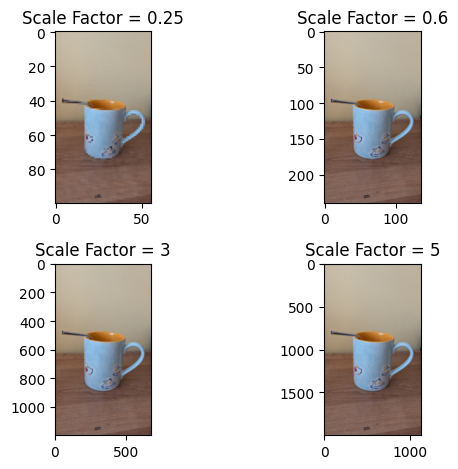

In [212]:
# Scale Invariance
scale_factors = [0.25, 0.6, 3, 5]
scaled_images = scale_images(img_a, scale_factors)
display_scaled_images(scale_factors, scaled_images)

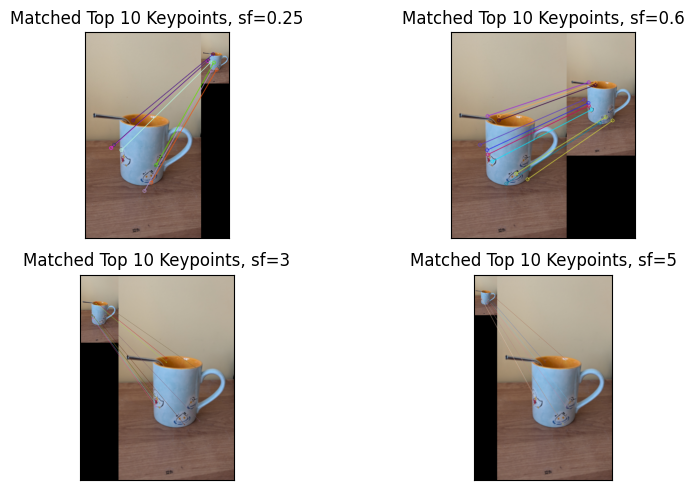

In [224]:
_ = display_scaled_matchings(img_a, scaled_images, scale_factors)

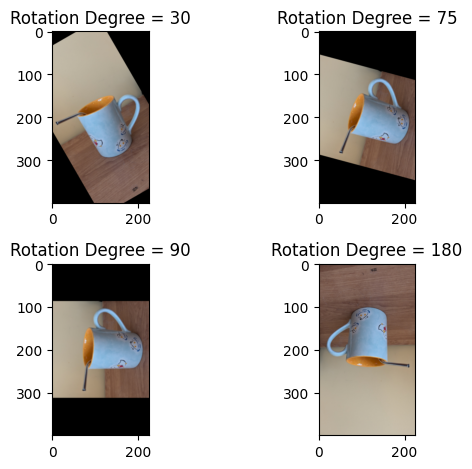

In [214]:
# Rotation Invariance
rotation_degrees = [30, 75, 90, 180]
rotated_images = rotate_images(img_a, rotation_degrees)
display_rotated_images(rotation_degrees, rotated_images)

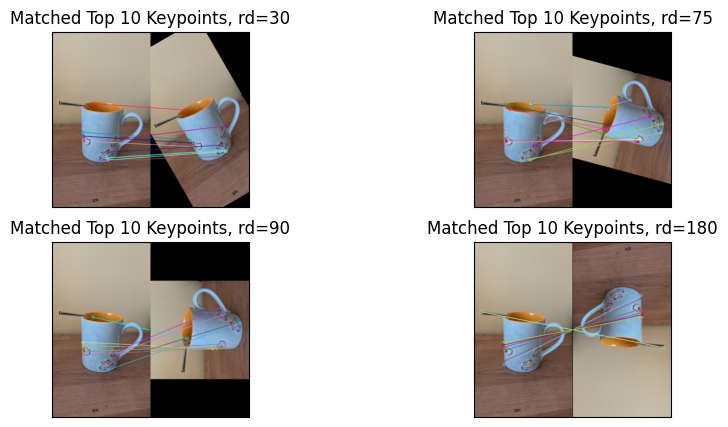

In [225]:
_ = display_rotated_matchings(img_a, rotated_images, rotation_degrees)

## 3 Image Stitching

### Keypoint Detection and Matching

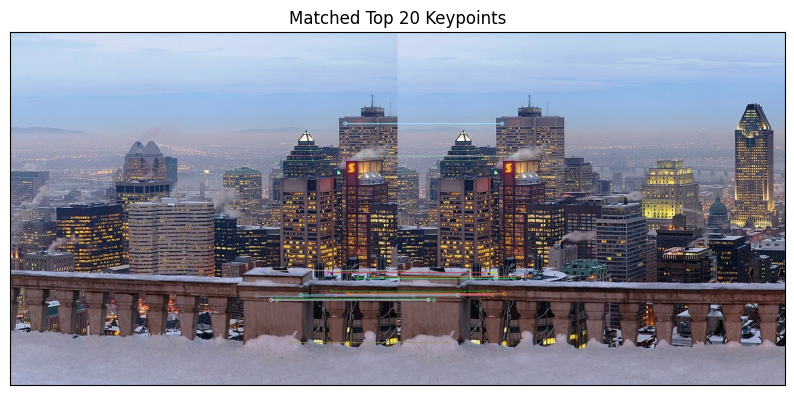

In [216]:
# load iamges
img1 = cv2.cvtColor(cv2.imread(path + "Q3/image_1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(path + "Q3/image_2.jpg"), cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread(path + "Q3/image_3.jpg"), cv2.COLOR_BGR2RGB)

# copy images
img1_disp = img1.copy()
img2_disp = img2.copy()

# create a SIFT detector
sift = cv2.SIFT_create()

# detect keypoints and compute SIFT descriptors
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

# match keypoints
# create BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# match descriptors
matches = bf.match(descriptors_1, descriptors_2)

# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)

# draw first 20 matches
img_matches = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:20], None, flags=2)

# display top 20 matches on images
plt.figure(figsize=(10, 10))
plt.imshow(img_matches)
plt.title("Matched Top 20 Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

### Homography Estimating and Transformation

In [217]:
# Arrange matching keypoints in two separate lists
mp1 = np.float32([keypoints_1[m.queryIdx].pt for m in matches[:20]])
mp2 = np.float32([keypoints_2[m.trainIdx].pt for m in matches[:20]])

# homography estimation
H, __ = cv2.findHomography(mp2, mp1, cv2.RANSAC, 4)

I was having issues when warpping image 1 first, instead I decided to warp image 2 first. In similar ordering as the tutorial (warpping the right image, then adding the left image on top of the warpped image).

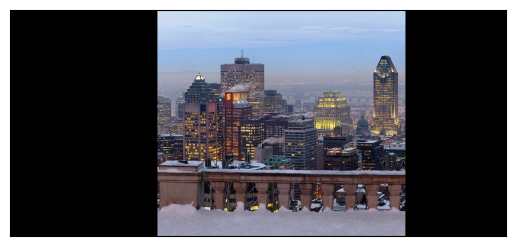

In [218]:
# warp image 2
img2_disp = cv2.warpPerspective(img2_disp, H, (img1.shape[1]+img2.shape[1], max(img1.shape[0], img2.shape[0])))

plt.imshow(img2_disp), plt.xticks([]), plt.yticks([])
plt.show()

### Image Stitching

In [219]:
# measure the gap,
# knowing that the image is in the middle of the final image
def measure_the_gap(img):
  counter = 0
  for i in range(img.shape[1])[::-1]:
    if np.all(img[0][i] == (0, 0, 0)):
      counter += 1
    else:
      break
  return counter

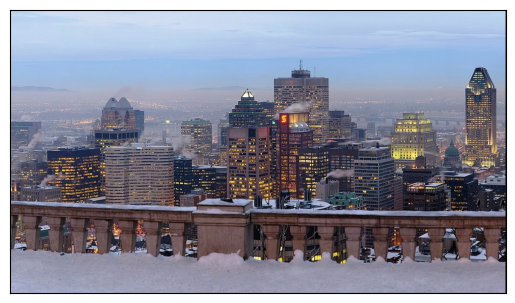

In [220]:
gap_size = measure_the_gap(img2_disp)

image_12 = img2_disp.copy()

# average the 2 images in the overlap area
overlap_area = image_12[:, img1.shape[1]-gap_size:img1.shape[1], :]

image_12[:, img1.shape[1]-gap_size:img1.shape[1], :] = overlap_area * 0.5
image_12[:, img1.shape[1]-gap_size:img1.shape[1], :] = overlap_area + (img1[:, img1.shape[1]-gap_size:img1.shape[1], :] * 0.5)
image_12[:, 0:img1.shape[1]-gap_size, :] = img1[:, 0:img1.shape[1]-gap_size, :]

# removing the black extra space
image_12 = image_12[:, :image_12.shape[1]-gap_size, :]

plt.imshow(image_12), plt.xticks([]), plt.yticks([])
plt.show()

### Final Stitching

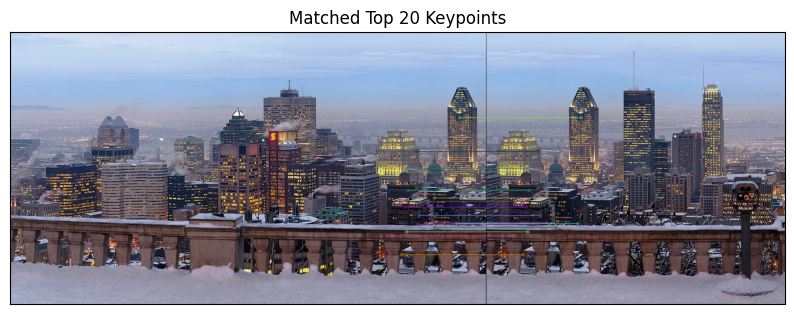

In [221]:
# stitching image 3 to image_12

# copy images
image_12_disp = image_12.copy()
img3_disp = img3.copy()

# create a SIFT detector
sift = cv2.SIFT_create()

# detect keypoints and compute SIFT descriptors
keypoints_1, descriptors_1 = sift.detectAndCompute(image_12, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img3, None)

# match keypoints
# create BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# match descriptors
matches = bf.match(descriptors_1, descriptors_2)

# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)

# draw first 20 matches
img_matches = cv2.drawMatches(image_12, keypoints_1, img3, keypoints_2, matches[:20], None, flags=2)

# display top 20 matches on images
plt.figure(figsize=(10, 10))
plt.imshow(img_matches)
plt.title("Matched Top 20 Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

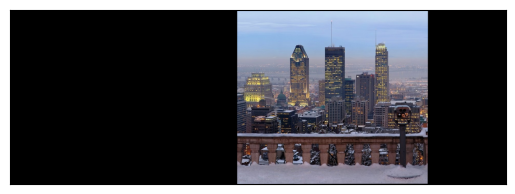

In [222]:
# Arrange matching keypoints in two separate lists
mp1 = np.float32([keypoints_1[m.queryIdx].pt for m in matches[:20]])
mp2 = np.float32([keypoints_2[m.trainIdx].pt for m in matches[:20]])

# homography estimation
H, __ = cv2.findHomography(mp2, mp1, cv2.RANSAC, 4)

# warp image 3
img3_disp = cv2.warpPerspective(img3_disp, H, (image_12.shape[1]+img3.shape[1], max(img1.shape[0], img3.shape[0])))

plt.imshow(img3_disp), plt.xticks([]), plt.yticks([])
plt.show()

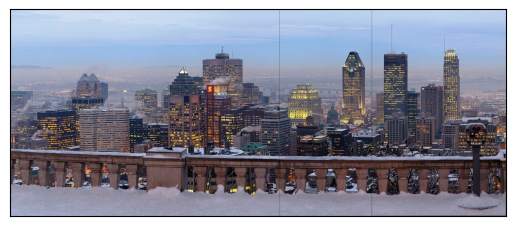

In [223]:
gap_size = measure_the_gap(img3_disp)

image_123 = img3_disp.copy()

# average the 2 images in the overlap area
overlap_area = image_123[:, image_12.shape[1]-gap_size:image_12.shape[1], :]

image_123[:, image_12.shape[1]-gap_size:image_12.shape[1], :] = overlap_area * 0.5
image_123[:, image_12.shape[1]-gap_size:image_12.shape[1], :] = overlap_area + (image_12[:, image_12.shape[1]-gap_size:image_12.shape[1], :] * 0.5)
image_123[:, 0:image_12.shape[1]-gap_size, :] = image_12[:, 0:image_12.shape[1]-gap_size, :]

# removing the black extra space
image_123 = image_123[:, :image_123.shape[1]-gap_size-1, :]

plt.imshow(image_123), plt.xticks([]), plt.yticks([])
plt.show()

## Resources
Harris corner and edge detection: https://medium.com/@itberrios6/harris-corner-and-edge-detector-4169312aa2f8

Code snippets adapted from ECSE 415 Tutorials, specifically Tutorial 3 and 4